# Operational Intelligence

Capture data in realtime and draw dashboards for you cannot improve what you cannot measure. When business shows a trend -- up or down -- it is imperative for you to stay ahead of the realtime intelligence and take proactive action versus reacting after the fact. 

Underneath we show a simple web analytics module that measures -- 

1. pre-eminent browser clients. 
2. pre-eminent countries of traffic over a simulated 3 day window. 

## Capture Realtime Data

Ideally in real world, you want to open a syslog daemon directly on top of the Spark Streaming context and receive data in near realtime. The idea is to aggregate, visualize, monitor, and alert any non-normative behavior. There are existing tools like ELK, SILK, Druid, and Splunk that already provide this intelligence out of the box, but this notebook is intended to be educational.

In [1]:
# To generate the socket stream, use the following code
from pyspark.streaming import StreamingContext

# Create the streamingcontext
# ssc = StreamingContext(sc)

# Create a DStream that will connect to hostname:port, like localhost:9999
# log_lines = ssc.socketTextStream("localhost", 9998)

# Start the socket monitor
# ssc.start() # Uncomment if necessary for realtime data

# Run perpetually updating the dashboards constantly.
# ssc.awaitTermination() #Uncomment if necessary for realtime data

## Simulated Local Data

Since we are running in a notebook context, let us just demonstrate the log processing with local log files. We are using log file sample downloaded from https://github.com/elastic/examples/tree/master/ElasticStack_apache

In [2]:
# Read the log file
log_lines = sc.textFile('apache_logs.txt')

# Review the format
log_lines.take(1)

[u'83.149.9.216 - - [17/May/2015:10:05:03 +0000] "GET /presentations/logstash-monitorama-2013/images/kibana-search.png HTTP/1.1" 200 203023 "http://semicomplete.com/presentations/logstash-monitorama-2013/" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.77 Safari/537.36"']

## Parse the log

In [3]:
import apache_log_parser

# Make a parser to parse out the web line
line_parser = apache_log_parser.Parser("%h %l %u %t \"%r\" %s %b \"%{Referer}i\" \"%{User-Agent}i\"")

# Parse and return interesting bits
def parse_line(logline):
    # Parse and return the dict as a Row of DataFrame
    row_dict = {}
    try:
        row_dict = { k:v for (k,v) in line_parser.parse(logline).iteritems() if 'datetimeobj' not in k}
    except:
        pass
    return row_dict

# For each log line, parse and show the parse result
import pprint
pprint.pprint(sc.parallelize(log_lines.take(1)).map(parse_line).filter(lambda x: len(x) > 5).collect()[0])

# Show a preview of the parse in a table form
# Collect only hits from mobile devices
log_lines_df = log_lines.map(parse_line).filter(lambda x: len(x) > 5).map(lambda x: Row(**x)).toDF(sampleRatio=0.5)

# Display the data
display(log_lines_df.toPandas())

{'remote_host': u'83.149.9.216',
 'remote_logname': u'-',
 'remote_user': u'-',
 'request_first_line': u'GET /presentations/logstash-monitorama-2013/images/kibana-search.png HTTP/1.1',
 'request_header_referer': u'http://semicomplete.com/presentations/logstash-monitorama-2013/',
 'request_header_user_agent': u'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.77 Safari/537.36',
 'request_header_user_agent__browser__family': u'Chrome',
 'request_header_user_agent__browser__version_string': '32.0.1700',
 'request_header_user_agent__is_mobile': False,
 'request_header_user_agent__os__family': 'Mac OS X',
 'request_header_user_agent__os__version_string': '10.9.1',
 'request_http_ver': u'1.1',
 'request_method': u'GET',
 'request_url': u'/presentations/logstash-monitorama-2013/images/kibana-search.png',
 'request_url_fragment': '',
 'request_url_hostname': None,
 'request_url_netloc': '',
 'request_url_password': None,
 'request_url_path'

,remote_host,remote_logname,remote_user,request_first_line,...,time_received,time_received_isoformat,time_received_tz_isoformat,time_received_utc_isoformat
0,83.149.9.216,-,-,GET /presentations/logstash-monitorama-2013/im...,...,[17/May/2015:10:05:03 +0000],2015-05-17T10:05:03,2015-05-17T10:05:03+00:00,2015-05-17T10:05:03+00:00
1,83.149.9.216,-,-,GET /presentations/logstash-monitorama-2013/im...,...,[17/May/2015:10:05:43 +0000],2015-05-17T10:05:43,2015-05-17T10:05:43+00:00,2015-05-17T10:05:43+00:00
2,83.149.9.216,-,-,GET /presentations/logstash-monitorama-2013/pl...,...,[17/May/2015:10:05:47 +0000],2015-05-17T10:05:47,2015-05-17T10:05:47+00:00,2015-05-17T10:05:47+00:00
...,...,...,...,...,...,...,...,...,...
9983,66.249.73.135,-,-,GET /?flav=atom HTTP/1.1,...,[20/May/2015:21:05:00 +0000],2015-05-20T21:05:00,2015-05-20T21:05:00+00:00,2015-05-20T21:05:00+00:00
9984,180.76.6.56,-,-,GET /robots.txt HTTP/1.1,...,[20/May/2015:21:05:56 +0000],2015-05-20T21:05:56,2015-05-20T21:05:56+00:00,2015-05-20T21:05:56+00:00
9985,46.105.14.53,-,-,GET /blog/tags/puppet?flav=rss20 HTTP/1.1,...,[20/May/2015:21:05:15 +0000],2015-05-20T21:05:15,2015-05-20T21:05:15+00:00,2015-05-20T21:05:15+00:00


## Browser traffic

Let us measure which countries and what browsers are most traffic originating from.

In [4]:
# Define a IP to country map
import pygeoip


def to_country(ip):
    geo_ip = pygeoip.GeoIP('GeoIP.dat')
    return geo_ip.country_code_by_addr(ip)


# Convert to a local frame; only selective columns
# Map the IP to a country from where the client is browsing
browser_frame = log_lines_df.select(
    'request_header_user_agent__browser__family', 'remote_host',
    'time_received_isoformat').withColumn(
        'country', F.udf(to_country)(F.col('remote_host'))).toPandas()

# Display the preview
pd_display(browser_frame, 'Timed traffic to the website')

,request_header_user_agent__browser__family,remote_host,time_received_isoformat,country
0,Chrome,83.149.9.216,2015-05-17T10:05:03,RU
1,Chrome,83.149.9.216,2015-05-17T10:05:43,RU
2,Chrome,83.149.9.216,2015-05-17T10:05:47,RU
...,...,...,...,...
9983,Googlebot,66.249.73.135,2015-05-20T21:05:00,US
9984,Firefox,180.76.6.56,2015-05-20T21:05:56,CN
9985,Other,46.105.14.53,2015-05-20T21:05:15,FR


Normalize to a local time

In [5]:
%matplotlib inline

from datetime import datetime

# The current browser time is in UTC time zone. Let us normalize that to current time
offset = datetime.now() - datetime.utcnow()  # Find offset first

# project the ISO time column to a local time column
browser_frame['local_time'] = browser_frame['time_received_isoformat'].apply(
    lambda x: pd.to_datetime(x) + pd.to_timedelta(offset, unit='s'))

# Offset the recorded time to local time zone and reindex the series
# Make the time axis labels pretty
browser_frame.set_index(pd.DatetimeIndex(browser_frame.local_time), inplace=True)

pd_display(browser_frame, 'Timed index normalized to local timezone')

,request_header_user_agent__browser__family,remote_host,time_received_isoformat,country,local_time
local_time,,,,,
2015-05-17 02:05:02.999989,Chrome,83.149.9.216,2015-05-17T10:05:03,RU,2015-05-17 02:05:02.999989
2015-05-17 02:05:42.999989,Chrome,83.149.9.216,2015-05-17T10:05:43,RU,2015-05-17 02:05:42.999989
2015-05-17 02:05:46.999989,Chrome,83.149.9.216,2015-05-17T10:05:47,RU,2015-05-17 02:05:46.999989
...,...,...,...,...,...
2015-05-20 13:04:59.999989,Googlebot,66.249.73.135,2015-05-20T21:05:00,US,2015-05-20 13:04:59.999989
2015-05-20 13:05:55.999989,Firefox,180.76.6.56,2015-05-20T21:05:56,CN,2015-05-20 13:05:55.999989
2015-05-20 13:05:14.999989,Other,46.105.14.53,2015-05-20T21:05:15,FR,2015-05-20 13:05:14.999989


## How does the browser patterns behave?

Cumulate count of browsers, countries-of-origin on a 4 hour basis and plot

In [6]:
# Pivot first so all status codes become columns
# Similarly pivot by countries too
def group_count(df, feature, resample='4H'):
    return df.groupby([pd.TimeGrouper(resample), feature])[feature].count().unstack(feature).fillna(0)

# Create a shortcut macro
counts = lambda feature: group_count(browser_frame, feature)

# Compute and show a count of browsers
browsers = counts('request_header_user_agent__browser__family')

# Show
pd_display(browsers, "Browser counts along time")

# Compute and show countries of origin by the hour
countries = counts('country')

# Show 
pd_display(countries, "Country counts along time")

request_header_user_agent__browser__family,360Spider,AOL,AhrefsBot,Amazon Silk,...,msnbot,msnbot-media,psbot,robot
local_time,,,,,,,,,
2015-05-17 00:00:00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0
2015-05-17 04:00:00,0.0,0.0,0.0,7.0,...,92.0,0.0,5.0,2.0
2015-05-17 08:00:00,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
2015-05-20 04:00:00,0.0,0.0,14.0,0.0,...,0.0,0.0,0.0,3.0
2015-05-20 08:00:00,0.0,0.0,14.0,0.0,...,0.0,0.0,0.0,2.0
2015-05-20 12:00:00,0.0,0.0,6.0,0.0,...,0.0,0.0,0.0,1.0


country,AE,AR,AT,AU,...,US,VE,VN,ZA
local_time,,,,,,,,,
2015-05-17 00:00:00,0.0,0.0,0.0,0.0,...,78.0,0.0,0.0,0.0
2015-05-17 04:00:00,0.0,0.0,4.0,0.0,...,227.0,0.0,0.0,0.0
2015-05-17 08:00:00,0.0,0.0,1.0,0.0,...,236.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2015-05-20 04:00:00,0.0,1.0,3.0,0.0,...,220.0,6.0,0.0,2.0
2015-05-20 08:00:00,0.0,0.0,1.0,0.0,...,264.0,0.0,0.0,0.0
2015-05-20 12:00:00,0.0,0.0,0.0,0.0,...,98.0,0.0,0.0,0.0


## Visualize

Let us visualize the browser and country counts.

### First, browser dist plots

Let us plot histograms/heatmap of browsers and peak traffic times first.

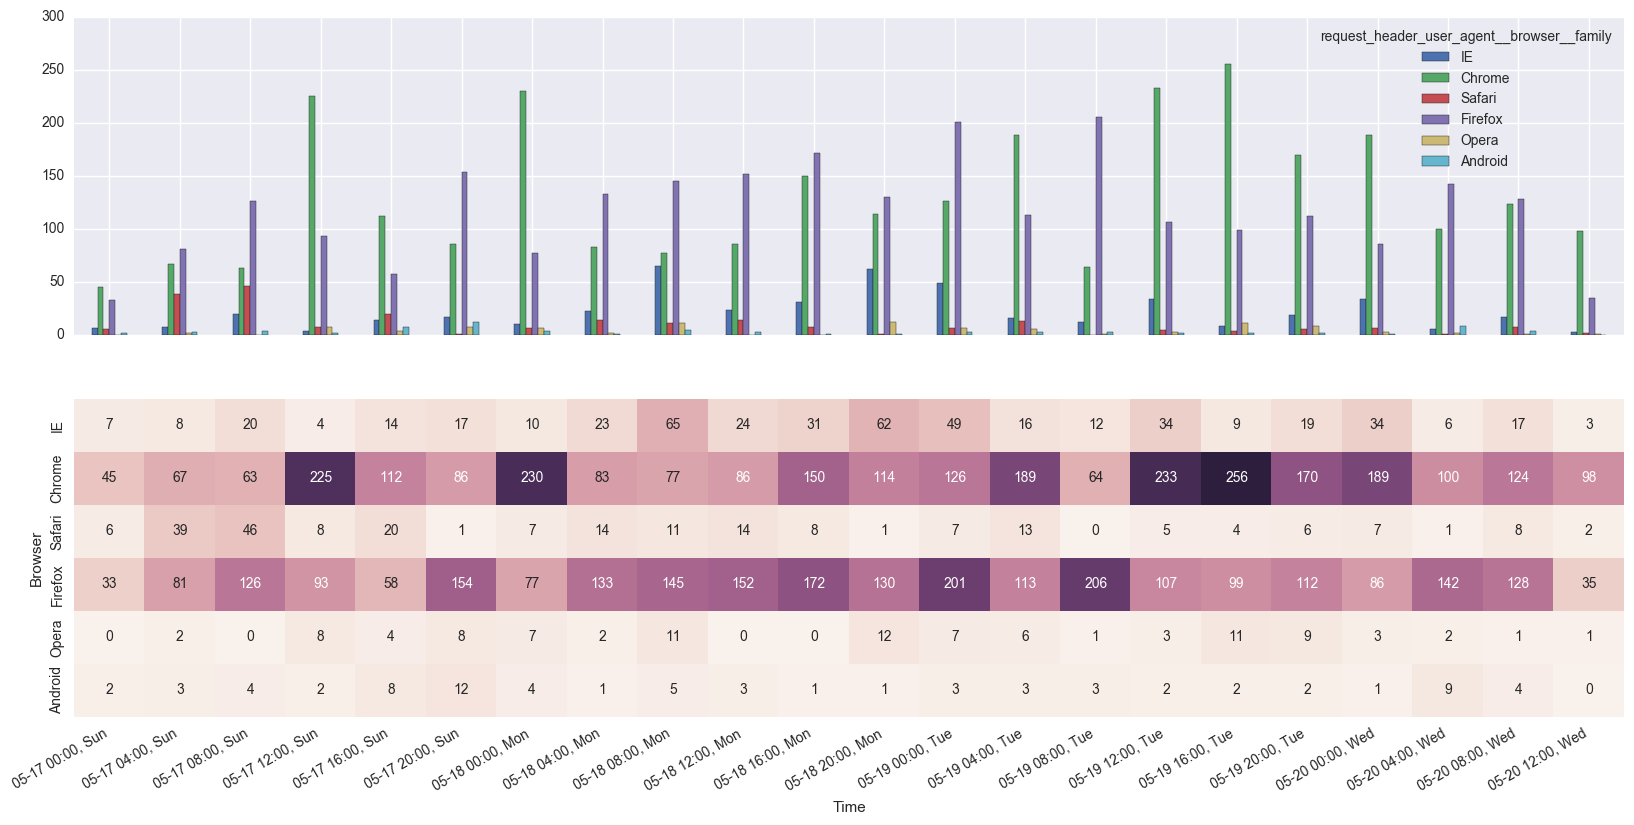

In [7]:
# Plot the time series chart
# We will add counts in integer form, so project everything as int
chart_data = browsers[['IE', 'Chrome', 'Safari', 'Firefox', 'Opera', 'Android']].astype(int)

# Make the time axis labels pretty
from matplotlib.dates import IndexDateFormatter, DateFormatter
from datetime import datetime
fmt = DateFormatter('%m-%d %H:%M, %a')
chart_data['Time'] = chart_data.index

# Format X axis in a friendly format
from matplotlib.dates import IndexDateFormatter, DateFormatter
fmt = DateFormatter('%m-%d %H:%M, %a')
chart_data['Time'] = chart_data['Time'].apply(lambda x: fmt.strftime(x))
chart_data.set_index('Time', inplace=True)

# ============================
# Create a figure
fig, ax = plt.subplots(2, 1, figsize=(20,10))
sns.set_style("whitegrid")

# Plot the bar chart
chart_data.plot(kind='bar', ax=ax[0])

# Plot the heatmap on the same axis
sns.heatmap(chart_data.T, annot=True, fmt="d", ax=ax[1], cbar=False)
ax[1].set(xlabel='Time', ylabel='Browser')
fig.autofmt_xdate()

### Traffic geo density

Let us also plot a geomap of where the client traffic is emanating from. Presumably, it varies over time. Since we have a moving window, let us use a interactive wizard for user to select a specific window of time when this responsive heatmap is desired.

In [8]:
# First let us geocode the country centers
from geopy.geocoders import Nominatim
geo_locator = Nominatim()

def get_latlng(ctry):
    result = geo_locator.geocode(ctry)
    (lat, lon) = (result[1][0], result[1][1]) if result else (0, 0)
    return (lat, lon)

# Make a dataframe with country short codes and lat/long codes
countries_data = pd.DataFrame(countries.columns.values, columns=['countries'])
countries_data['latlng'] = countries_data.countries.apply(lambda ctry: get_latlng(ctry))
countries_data['latitudes'] = countries_data['latlng'].apply(lambda x: float(x[0]))
countries_data['longitudes'] = countries_data['latlng'].apply(lambda x: float(x[1]))
# Save this data for future time-lapsed heatmap plots
countries_data.set_index('countries', inplace=True)

#### Based on a user selection, generate a responsive map

In [9]:
# To make the geo map interactive so users can select a time, create a interactive drop-down wizard
# Make a map
import folium
import folium.plugins as plugins

# The following widgets allow for interactively progressing a time-lapse window and studying the heatmap
from IPython.html.widgets import interact
from IPython.html import widgets
from folium.plugins import HeatMap


# At a give chosen time, plot a heatmap of countries where clients are
def plot_traffic(Time):
    x = list(countries.index.values)[Time]
    
    # First print the time back so users have better since of the observation window
    display(
        HTML("<h4>Heatmap at {0}</h4>".format(
            fmt.strftime(pd.to_datetime(str(x))))))

    # Select frequencies at the user-chosen time and join with lat-long intelligence
    ctry = countries[countries.index == x].T.join(countries_data)
    ctry.rename(columns={ctry.columns[0]: 'timeval'}, inplace=True)

    #Now we have lat, long, and freq of country information for the hour in a singular row
    ctry = ctry[ctry[ctry.columns[0]] > 0]

    # Make a brand new map. I wish we could re use the prior map. TODO
    countries_map = folium.Map(location=[
        countries_data['latitudes'].mean(), countries_data['longitudes'].mean()
    ], zoom_start=2)  # Always zoom out to the world
    
    # Make a group layer
    feature_group = folium.FeatureGroup(name=str(x))
    
    # Make a heatmap
    heatmap = folium.plugins.HeatMap(
        ctry[['latitudes', 'longitudes', 'timeval']].values, radius=15)

    # Add the heatmap to the world
    feature_group.add_children(heatmap)
    countries_map.add_children(feature_group)

    # return the map to paint on the canvas
    return countries_map


# Display an interactive slider for user to choose a time when the heatmap is to be visualized
# Place the slider to the middle of the ibservation window
display(
    interact(
        plot_traffic,
        Time=widgets.IntSlider(
            value=len(countries.index.values)/2, min=0, max=len(countries.index.values))));

<function __main__.plot_traffic>

## Findings

1. We find the activity peaks in the evening (PST) versus midnight, midday, or dawn
2. It is a very short window but it looks like Tuesday seems like a peak day for business
3. Chrome and Firefox seem to be the eminent browsers.
4. Majority of the traffic, at least in specific observed windows, seems to come mostly from European countries.
5. There are clients of ~90 countries that visited the website during the 3 day observation window.

# Conclusions

Though this is a simple BI dashboard, it goes to demonstrate how easy it is to build operational intelligence into your business systems so you are not caught off-guard when business metrics start to spike-up or trend-down. While this isn't preemptive intelligence, it surely paves way for proactive intelligence.